Import the necessary modules

In [ ]:
import re
from collections import Counter
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image
from dataloaders import get_loaders
import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split # Dividing train test
from nltk.translate.bleu_score import corpus_bleu # BLEU Score
print("PyTorch Version: ",torch.__version__)

In [2]:
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Generate Vocabulary, Train and Test loader using get_loaders from dataloaders.py

In [3]:
train_loader, test_loader, vocab = get_loaders(64)

Vizualize a batch

In [4]:
data, target = next(iter(train_loader))

In [5]:
print(data.shape)
print(target.shape)
print(target[0])
print(target[1])
lst = []
for elem in target[1]:
    lst.append(vocab.itos[elem.item()])
print(lst)

torch.Size([64, 3, 224, 224])
torch.Size([64, 29])
tensor([   1,    5, 1112,    4,   13,  311,   87,  509,  160,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])
tensor([   1,  343,   98,   44,    8, 1293,    3,  274,    4,   13,  176,   60,
        1167,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])
['<SOS>', 'male', 'child', 'playing', 'on', 'round', '<UNK>', 'ride', 'in', 'the', 'park', 'by', 'himself', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


Vizualize Image

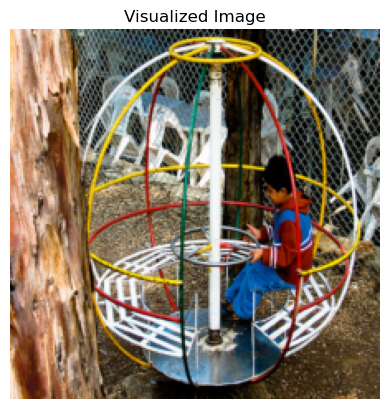

In [6]:
im = data[1]
im = im.permute(1, 2, 0).cpu().numpy()  # Convert from [C, H, W] to [H, W, C] and move to CPU


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Denormalize
im = std * im + mean  
im = np.clip(im, 0, 1)  

# Display the image 
plt.imshow(im)
plt.title("Visualized Image")
plt.axis('off')  
plt.show()

Define Models

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
resnet101 = models.resnet101(pretrained=True)

Remove the last layer(Change with Identity)

In [9]:

resnet50.fc = nn.Identity()

In [10]:

resnet101.fc = nn.Identity()

Freeze model

In [11]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

In [12]:
freeze_model(resnet50)

In [13]:
freeze_model(resnet101)

Define the Attention

In [14]:
class Attention(nn.Module):
      
    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(Attention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
       
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)
                
    def forward(self, features, decoder_hidden):
        
        # add additional dimension (required for summation)
        decoder_hidden = decoder_hidden.unsqueeze(1)
        
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)

        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)

        
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight

Define the Encoder

In [15]:
class CNN_Encoder(nn.Module):
    def __init__(self,cnn_model,cnn_output_size, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.cnn = cnn_model
        self.embedding_dim = embedding_dim
        self.cnn_output_size = cnn_output_size
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.cnn_output_size ,self.embedding_dim)
    def forward(self, x):
        features= self.cnn(x)
        features = self.fc(features)
        return features

Define The Encoder Attention

In [16]:
class Encoder_Attention(nn.Module):
    
    def __init__(self):
        super(Encoder_Attention, self).__init__()
        resnet = models.resnet101(pretrained=True)
        freeze_model(resnet)
        
        #Use the feature maps before the linear layer
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        # first, we need to resize the tensor to be 
        # (batch, size*size, feature_maps)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
       
        return features

Define the Decoder

In [17]:
class LSTM_Deconder(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, hidden_dim, n_layers, drop_prob=0.):
        super(LSTM_Deconder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_dim)
        self.dropout = nn.Dropout(drop_prob)
        self.prelu = nn.PReLU()
    def forward(self, x, h, c=None):
        emb = self.embedding(x)
        out, (h, c) = self.lstm(emb, (h, c))
        out =self.fc1(out)
        out = self.prelu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out, h, c
    '''-
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        weight = next(self.parameters()).data
        if self.rnn_cell == 'LSTM': # in LSTM we have a cell state and a hidden state
            return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(), weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        else:                       # in GRU and RNN we only have a hidden state
            return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(), None
    '''

Define the Decoder Attention

In [18]:
class Decoder_Attention(nn.Module):
    
    def __init__(self, num_features, embedding_dim, hidden_dim, vocab_size,n_layers, p =0.5):

        super(Decoder_Attention, self).__init__()
        
        self.num_features = num_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
       
        # Use LSTMCell to be provide at each step the context vector from the attention block
        # concatenated with the embedding of the respective word
        self.lstm = nn.LSTMCell(embedding_dim + num_features, hidden_dim)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        self.attention = Attention(num_features, hidden_dim)

        self.drop = nn.Dropout(p=p)
        
        self.init_h = nn.Linear(num_features, hidden_dim)
        self.init_c = nn.Linear(num_features, hidden_dim)

    def forward(self, captions, features):
        
        embed = self.embeddings(captions)
    
        h, c = self.init_hidden(features)
        seq_len = captions.size(1)
        feature_size = features.size(1)
        batch_size = features.size(0)

        # these will be the final outputs
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)

        
        for t in range(seq_len):
            
            word_embed = embed[:,t,:]
            context, atten_weight = self.attention(features, h)

            #concatenate the output given by the attention block with the embedding of the word
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight
            
        return outputs, atten_weights

    def init_hidden(self, features):

        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0

Encoder + Decoder Model

In [19]:
class CNNLSTMModel(nn.Module):
    def __init__(self, cnn_model, lstm_decoder):
        super(CNNLSTMModel, self).__init__()
        self.cnn = cnn_model
        self.lstm_decoder = lstm_decoder
        
    def forward(self, x):
        features = self.cnn(x[0])
        decoder_features=torch.reshape(features,(1,features.shape[0],-1))
        out = self.lstm_decoder(x[1],decoder_features,decoder_features)
        
        return out

Encoder+Decoder Attention

In [20]:
class EncoderDecoder_ATT(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs, atten_weigths = self.decoder(captions, features)
        return outputs, atten_weigths

Hyperparameters

In [21]:
cnn_output_size = 2048
embedding_dim = 512
vocab_dim = len(vocab.stoi)
hidden_dim =512
n_layers = 1

Models

In [22]:
encoder_att = Encoder_Attention()
decoder_att = Decoder_Attention(num_features=cnn_output_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                                vocab_size=vocab_dim,n_layers=n_layers, p =0.5)

model_att = EncoderDecoder_ATT(encoder_att,decoder_att)

In [ ]:
encoder = CNN_Encoder(resnet101,cnn_output_size,embedding_dim)
decoder = LSTM_Deconder(vocab_dim,embedding_dim,hidden_dim,n_layers,drop_prob=0.25)
model = CNNLSTMModel(encoder,decoder)
model.to(device)

Check if the model is well connected

In [24]:
model_att.to(device)
with torch.no_grad():

    data, target = next(iter(train_loader))
    data, target = data.to(device), target.to(device)
    print(data[0].shape)
    outputs, att_weigths = model_att(data,target)

    print(outputs.shape)
    

torch.Size([3, 224, 224])
torch.Size([64, 25, 6912])


In [ ]:
model.to(device)
with torch.no_grad():

    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    print(data[0].shape)
    output,h,c = model((data,target))

    print(output.shape)
    print(output)

Check how many layers are trainable and how many are frozen

In [26]:
def count_trainable_and_frozen_layers(model):
    trainable_layers = 0
    frozen_layers = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_layers += 1
        else:
            frozen_layers += 1
    
    return trainable_layers, frozen_layers

# Count and print the number of trainable and frozen layers
trainable_layers, frozen_layers = count_trainable_and_frozen_layers(model)
print(f"Trainable layers: {trainable_layers}")
print(f"Frozen layers: {frozen_layers}")

Trainable layers: 12
Frozen layers: 312


Prepare for training

In [27]:
#Optimizer for Attention model
params_to_update = []
for name, param in model_att.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


lr = 1e-4*3
optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)
#Criterion
criterion = nn.CrossEntropyLoss()
num_epochs = 30

In [28]:
#Optimizer for simple model
params_to_update_simple = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update_simple.append(param)


lr = 1e-4*3
optimizers_simple = optim.Adam(params_to_update_simple, lr=lr, weight_decay=1e-4)

scheduler_simple = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)
#Criterion
criterion = nn.CrossEntropyLoss()
num_epochs = 30

In [29]:
def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()
        gt = target[:,1:]
        target = target[:,0:-1]
        data, target,gt = data.to(device), target.to(device),gt.to(device)
        
        output,h,c = model((data,target))

        #Reshape the output for CrossEntropy
        batch_size, sequence_length, num_classes = output.size()
        output = output.view(batch_size * sequence_length, num_classes)
        gt = gt.view(batch_size * sequence_length)

        loss = criterion(output, gt)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item() 

    return total_loss / len(loader.dataset)

train att

In [30]:
def train_att(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()
        gt = target[:,1:]
        target = target[:,0:-1]
        data, target,gt = data.to(device), target.to(device),gt.to(device)
        
        output,att_weigths = model(data,target)

        #Reshape the output for CrossEntropy
        batch_size, sequence_length, num_classes = output.size()
        output = output.view(batch_size * sequence_length, num_classes)
        gt = gt.view(batch_size * sequence_length)

        loss = criterion(output, gt)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item() 

    return total_loss / len(loader.dataset)

Train Attention

In [61]:
losses_att = []
for epoch in range(1):

    train_loss = train_att(epoch, criterion, model_att, optimizer, train_loader)
    scheduler.step()
    losses_att.append(train_loss)
    print(losses_att[-1])

Train Epoch: 0 [0/127130 (0%)]	Loss: 1.751960
Train Epoch: 0 [6400/127130 (5%)]	Loss: 1.138964
Train Epoch: 0 [12800/127130 (10%)]	Loss: 1.572288
Train Epoch: 0 [19200/127130 (15%)]	Loss: 1.501585
Train Epoch: 0 [25600/127130 (20%)]	Loss: 1.535298
Train Epoch: 0 [32000/127130 (25%)]	Loss: 1.110914
Train Epoch: 0 [38400/127130 (30%)]	Loss: 1.947812
Train Epoch: 0 [44800/127130 (35%)]	Loss: 1.647699
Train Epoch: 0 [51200/127130 (40%)]	Loss: 1.269770
Train Epoch: 0 [57600/127130 (45%)]	Loss: 1.370469
Train Epoch: 0 [64000/127130 (50%)]	Loss: 1.303755
Train Epoch: 0 [70400/127130 (55%)]	Loss: 1.663684
Train Epoch: 0 [76800/127130 (60%)]	Loss: 1.682986
Train Epoch: 0 [83200/127130 (65%)]	Loss: 1.517219
Train Epoch: 0 [89600/127130 (70%)]	Loss: 1.225482
Train Epoch: 0 [96000/127130 (75%)]	Loss: 0.978086
Train Epoch: 0 [102400/127130 (81%)]	Loss: 1.565901
Train Epoch: 0 [108800/127130 (86%)]	Loss: 1.825843
Train Epoch: 0 [115200/127130 (91%)]	Loss: 1.363879
Train Epoch: 0 [121600/127130 (96%)

Train the baseline

In [ ]:

losses = []
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    scheduler.step()
    losses.append(train_loss)
    print(losses[-1])

Save model

Save the baseline

In [ ]:
model_save_path = "30krnnlstm_model_5.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")
e_model_save_path = "30kencoder_model_5.pth"
torch.save(encoder.state_dict(), e_model_save_path)
print(f"Model weights saved to {e_model_save_path}")

d_model_save_path = "30kdecoder_model_5.pth"
torch.save(decoder.state_dict(), d_model_save_path)
print(f"Model weights saved to {d_model_save_path}")

Save Attention

In [ ]:
model_save_path = "30k_att_model.pth"
torch.save(model_att.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")
e_model_save_path = "30k_att_e_model.pth"
torch.save(encoder_att.state_dict(), e_model_save_path)
print(f"Model weights saved to {e_model_save_path}")

d_model_save_path = "30k_att_d_model.pth"
torch.save(decoder_att.state_dict(), d_model_save_path)
print(f"Model weights saved to {d_model_save_path}")

Load model

In [88]:
model_save_path = "30krnnlstm_model_4.pth"
e_model_save_path = "30kencoder_model_4.pth"
d_model_save_path = "30kdecoder_model_4.pth"
model_att.load_state_dict(torch.load(model_save_path))
decoder_att.load_state_dict(torch.load(d_model_save_path))
encoder_att.load_state_dict(torch.load(e_model_save_path))

<All keys matched successfully>

Predict

In [ ]:
model.eval()
encoder.eval()
decoder.eval()
id = 12 # Image id
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
    
    
        data, target = data.to(device), target.to(device)
        for id in range(10):
            pred = []
            img = data[id].unsqueeze(0)
            features = encoder(img)
            decoder_features=torch.reshape(features,(1,features.shape[0],-1))
            h = decoder_features
            c = decoder_features
            word = target[0][0].unsqueeze(0).unsqueeze(0)
            
            for i in range(len(target[0])-1):
                y_pred, h, c = decoder(word,h,c)
                word = torch.argmax(y_pred, dim=2)
                pred.append(word.item())



            words_pred = []
            words_true = []
            for idx in pred:
                words_pred.append(vocab.itos[idx])

            for idx in target[id]:
                words_true.append(vocab.itos[idx.item()])

            #Print image
            img = img.squeeze(0)
            print(img.shape)
            img = img.permute(1, 2, 0).cpu().numpy()  # Convert from [C, H, W] to [H, W, C] and move to CPU
            

            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]

            # Denormalize
            img = std * img + mean  
            img = np.clip(img, 0, 1)  

            # Display the image 
            plt.imshow(img)
            plt.title("Visualized Image")
            plt.axis('off')  
            plt.show()

            pred =""
            for word in words_pred:
                if word =="<PAD>":
                    break
                pred+=word+" "

            true =""
            for word in words_true:
                if word =="<SOS>":
                    continue
                if word =="<PAD>":
                    break
                true+=word+" "
            print("Prediction: ",pred)
            print("Truth :",true)

        break

Predict for Attention

torch.Size([3, 224, 224])


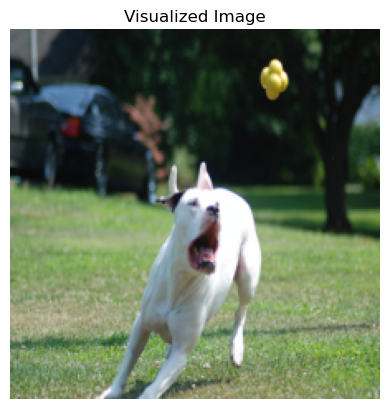

Prediction:  a white dog is running through a field <EOS>
Truth : <SOS> a dog prepares to catch a thrown object in a field with nearby cars


In [99]:
model_att.eval()
encoder_att.eval()
decoder_att.eval()
max_len = 50
id = 1 # Modify the index of the image
with torch.no_grad():
    iterator = iter(test_loader)
    next(iterator)
    imgs, target = next(iterator)
    img = imgs[id:id+1]

    features = encoder_att(img.to(device))
    batch_size = features.size(0)
    h,c = decoder_att.init_hidden(features)

    word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
    embeds = decoder_att.embeddings(word)
    
    captions = []
        
    for i in range(max_len):
        context,att_weigths = decoder_att.attention(features,h)

        lstm_input = torch.cat((embeds[:,0],context),dim =1)
        h,c = decoder_att.lstm((lstm_input),(h,c))
        output = decoder_att.fc(decoder_att.drop(h))
        output = output.view(batch_size,-1)

        predicted_word_idx = output.argmax(dim=1)
            
            
        captions.append(predicted_word_idx.item())
            
            
        if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            
        embeds = decoder_att.embeddings(predicted_word_idx.unsqueeze(0))

    words = [vocab.itos[idx] for idx in captions]

    sentence_pred = ' '.join(words)

    words_true = []
    for idx in target[id]:
        if vocab.itos[idx.item()] == "<EOS>": 
            break    
        words_true.append(vocab.itos[idx.item()])
    
    sentence_true = ' '.join(words_true)
            #Print image
    img = img.squeeze(0)
    print(img.shape)
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert from [C, H, W] to [H, W, C] and move to CPU
            

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

            # Denormalize
    img = std * img + mean  
    img = np.clip(img, 0, 1)
            # Display the image 
    plt.imshow(img)
    plt.title("Visualized Image")
    plt.axis('off')  
    plt.show()

    
    print("Prediction: ",sentence_pred)
    print("Truth :",sentence_true)
        

BLEU score for simple model

In [ ]:
model.eval()
encoder.eval()
decoder.eval()
#id = 45 # Image id
ct = 0
with torch.no_grad():
    all_words_pred = []
    all_words_true = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        ct+=1
        for id in range(len(data)):
            pred = []
            img = data[id].unsqueeze(0)
            features = encoder(img)
            decoder_features=torch.reshape(features,(1,features.shape[0],-1))
            h = decoder_features
            c = decoder_features
            word = target[0][0].unsqueeze(0).unsqueeze(0)
            
            for i in range(len(target[0])-1):
                y_pred, h, c = decoder(word,h,c)
                word = torch.argmax(y_pred, dim=2)
                pred.append(word.item())



            words_pred = []
            words_true = []
            for idx in pred:
                if vocab.ind2word[idx] == '<PAD>':
                    break
                words_pred.append(vocab.ind2word[idx])
            all_words_pred.append([words_pred])

            for idx in target[id]:
                if vocab.ind2word[idx.item()] == '<SOS>':
                    continue
                if vocab.ind2word[idx.item()] == '<PAD>':
                    break
                words_true.append(vocab.ind2word[idx.item()])
            all_words_true.append(words_true)
        
    #print(all_words_true)
    #print(all_words_pred)
    print('BLEU-1: %f' % corpus_bleu(all_words_pred, all_words_true, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(all_words_pred, all_words_true, weights=(0.5, 0.5, 0, 0))) 


BLEU Attention 

In [ ]:
#Calculate BLEU score for one batch, if you have time do it for all (flickr30k images)
model_att.eval()
encoder_att.eval()
decoder_att.eval()
max_len = 50
no_batches=3
ct=0
with torch.no_grad():

    all_sentences_pred = []
    all_sentences_true = []
    for batch_idx , (imgs,target) in enumerate(test_loader):
    #imgs, target = next(iter(test_loader))
    
        for id in range(len(imgs)):
            img = imgs[id:id+1]

            features = encoder_att(img.to(device))
            batch_size = features.size(0)
            h,c = decoder_att.init_hidden(features)

            word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
            embeds = decoder_att.embeddings(word)
            
            captions = []
                
            for i in range(max_len):
                context,att_weigths = decoder_att.attention(features,h)

                lstm_input = torch.cat((embeds[:,0],context),dim =1)

                h,c = decoder_att.lstm((lstm_input),(h,c))
                output = decoder_att.fc(decoder_att.drop(h))
                output = output.view(batch_size,-1)

                predicted_word_idx = output.argmax(dim=1)
                    
                    
                captions.append(predicted_word_idx.item())
                    
                    
                if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                        break
                    
                    
                embeds = decoder_att.embeddings(predicted_word_idx.unsqueeze(0))

            words = [vocab.itos[idx] for idx in captions]

            
            all_sentences_pred.append([words])
            
            words_true = []
            for idx in target[id]:
                if vocab.itos[idx.item()] == "<SOS>": 
                    continue    
                if vocab.itos[idx.item()] == "<PAD>": 
                    break    
                words_true.append(vocab.itos[idx.item()])
            all_sentences_true.append(words_true)
            
        ct+=1
        if ct > no_batches:
             break
        

print('BLEU-1: %f' % corpus_bleu(all_sentences_pred, all_sentences_true, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(all_sentences_pred, all_sentences_true, weights=(0.5, 0.5, 0, 0))) 